# Alouette-Error-Detection-Analysis
***
While browsing and processing Alouette's ionograms, the team found images with weird shapes (irregularly cropped), images with two ionograms (out of phase) or images with parts of ionograms (cropped too soon or out of phase). The goal of the following script is to find those ionograms and verify how big of an issue it is.

Before running this script, you need to run error_detection/scan_error_processor.py on your images. Depending on the size of your sample, it could take a couple of days. The present notebook use the BATCH_II ionograms.

Once it's done, you'll need to concatenate all the results file together. Depending on the number of csv to concatenate, it could take several minutes.

In [16]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
pd.options.mode.chained_assignment = None  # Remove Setting with copy warning in pandas

In [18]:
def concatResults(rootDir,resultDir):
    
    df_result = pd.DataFrame()
    i = 0
    for file in os.listdir(resultDir):
        if 'R' in file:
            directory = file
            for file2 in os.listdir(resultDir + directory + '/'):
                if 'result_scan_error_detect-' in file2:
                    fn_parts = file2.split('_')
                    subdirectory = fn_parts[1].replace('.csv', '')
                    if i > 0:
                        if i % 100 == 0:
                            df_result = pd.read_csv(resultDir + 'result_BATCH_II_raw.csv', low_memory=False)
                            print(len(df_result))
                    try:
                        df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                        n = len(df_load)
                    except pd.errors.EmptyDataError:
                        n = 0
                        df_load = pd.DataFrame()
                    df_result = pd.concat([df_result, df_load])
                    i += 1
                    if i % 100 == 0:
                        print('Now saving the ' + str(i) + 'th result...')
                        df_result.to_csv(resultDir + 'result_BATCH_II_raw.csv', index=False)
    return(df_result)

rootDir = 'L:/DATA/Alouette_I/BATCH_II_scan_error_detection_Run1/'
resultDir = rootDir + '01_result/'

df_result = concatResults(rootDir,resultDir)
# I suggest to save it so you don't have to re-do this operation
# df_result.to_csv(resultDir + 'result_BATCH_II_raw.csv', index=False)

Now saving the 100th result...
17386
Now saving the 200th result...
46915
Now saving the 300th result...
79876
Now saving the 400th result...
109334
Now saving the 500th result...
150055
Now saving the 600th result...
185530
Now saving the 700th result...
216813
Now saving the 800th result...
245998
Now saving the 900th result...
275605
Now saving the 1000th result...
305466
Now saving the 1100th result...
333771
Now saving the 1200th result...
362100
Now saving the 1300th result...
393133
Now saving the 1400th result...
419519
Now saving the 1500th result...
448678
Now saving the 1600th result...
478090
Now saving the 1700th result...
507578
Now saving the 1800th result...
536785
Now saving the 1900th result...
553640
Now saving the 2000th result...
584312
Now saving the 2100th result...
617904
Now saving the 2200th result...
651856
Now saving the 2300th result...
686679
Now saving the 2400th result...
719466


Part of the following code was taken from Ashley's work, which is in *24_Scan Error Detection Results Analysis.ipynb*. It gives us an idea of how many programming errors there are and if there are ISIS subdirectories in the sample.

In [19]:
total_len = len(df_result)

# filter out error rows
df_result = df_result.loc[df_result['says_isis'] != 'ERR']
filtered_down_len_1 = len(df_result)
print('rows filtered out due to errors:', total_len - filtered_down_len_1)

# drop dupplicates
df_result.drop_duplicates(inplace=True)
filtered_down_len_2 = len(df_result)
print('rows filtered out due to dupplicates:', filtered_down_len_1 - filtered_down_len_2)
    
# ISIS text on images
df_isis = df_result.loc[df_result['says_isis'] == 'True']
isis_img_pct = 100*len(df_isis)/filtered_down_len_2
print('total number of images:', filtered_down_len_2)
print('number of images with flagged ISIS text:', len(df_isis))
print('percentatge of ionogram images with flagged ISIS text:', round(isis_img_pct,  3), '%\n\n')
    
# unique ISIS subdirectories
subdirs_isis = df_isis['Subdirectory']
unique_subdirs_isis = set(subdirs_isis)
subdirs_tot = df_result['Subdirectory']
unique_subdirs_tot = set(subdirs_tot)
isis_subdir_pct = 100*len(unique_subdirs_isis)/len(unique_subdirs_tot)
print('total number of subdirectories:', len(unique_subdirs_tot))
print('number of subdirectories with flagges ISIS text:', len(unique_subdirs_isis))
print('percentatge of subdirectories with flagged ISIS text:', round(isis_subdir_pct,  3), '%\n\n')

rows filtered out due to errors: 212
rows filtered out due to dupplicates: 0
total number of images: 726365
number of images with flagged ISIS text: 256
percentatge of ionogram images with flagged ISIS text: 0.035 %


total number of subdirectories: 2416
number of subdirectories with flagges ISIS text: 42
percentatge of subdirectories with flagged ISIS text: 1.738 %




Let's see how the results look like with histograms for aspect ratio and the number of digits on each images.

In [48]:
def aspectPlot(df,ylabel,title,percent=False):
    
    # calculate aspect ratios
    aspect_ratios = df['aspect']
    
    fig, ax = plt.subplots()
    
    # make histogram data more clear (larger bins and more zoomed in)
    if percent : 
        ax.hist(aspect_ratios, bins=np.arange(0.0, 10.0, 0.20), alpha=0.8, weights=np.ones(len(df)) / len(df))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    else :
        ax.hist(aspect_ratios, bins=np.arange(0.0, 10.0, 0.20), alpha=0.8)
    
    ax.set_xlabel('width/height [pixels]')
    ax.set_ylabel(ylabel)
    ax.set_xlim(0,10)
    ax.set_xticks(np.arange(0.0, 10.0, 1.0),minor=True)
    ax.grid(which='both',axis='x',alpha=0.7,ls='--')
    
    # add vertical line at w/h = 1.2
    #plt.vlines(x=1.2, ymin=0, ymax=120000, colors='purple', linestyles='--', label='width / height =1.2')
    #plt.legend()
    
    mu = aspect_ratios.mean()
    med = aspect_ratios.median()
    sigma = aspect_ratios.std()
    
    textstr = '\n'.join((
        r'$\mathrm{average}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (med, ),
        r'$\mathrm{std}=%.2f$' % (sigma, )))
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgrey')
    
    # place a text box in upper left in axes coords
    fig.text(0.7, 0.8, textstr,va='top', bbox=props)
    fig.suptitle(title)
    
    n = len([ x for x in aspect_ratios if x < 2 ])
    print(round(100*n/filtered_down_len_2,2), '% of ionograms have w/h < 2')
    n = len([ x for x in aspect_ratios if x >= 3 ])
    print(round(100*n/filtered_down_len_2,2), '% of ionograms have w/h >= 3')
    
    return()

def digitPlot(df,ylabel,title,percent=False):
    
    # log histogram of metadata readings
    digit_counts = df['digit_count'].astype(float)
    
    fig, ax = plt.subplots()
    
    if percent :
        ax.hist(digit_counts, bins=np.arange(0., 60., 5.), alpha=0.8, weights=np.ones(len(df)) / len(df))
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    else :
        ax.hist(digit_counts, bins=np.arange(0., 60., 5.), alpha=0.8)
    ax.set_xlabel('total digits detected in ionogram [count]')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(0., 60., 5.),minor=True)
    ax.grid(which='both',axis='x',alpha=0.7,ls='--')
    
    mu = digit_counts.mean()
    med = digit_counts.median()
    sigma = digit_counts.std()
    
    textstr = '\n'.join((
        r'$\mathrm{average}=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (med, ),
        r'$\mathrm{std}=%.2f$' % (sigma, )))
    
    props = dict(boxstyle='round', facecolor='white', edgecolor='lightgrey')
    fig.text(0.7, 0.8, textstr,va='top', bbox=props)
    fig.suptitle(title)
    
    # percentage with digit_count > 15 and <= 10
    n = len([ x for x in digit_counts if x >= 16 ])
    print(round(100*n/filtered_down_len_2,2), '% of ionograms have digit_count > 15')
    n = len([ x for x in digit_counts if x < 10 ])
    print(round(100*n/filtered_down_len_2,2), '% of ionograms have digit_count < 10')

    return()

15.0 % of ionograms have w/h < 2
20.18 % of ionograms have w/h >= 3
7.59 % of ionograms have digit_count > 15
47.25 % of ionograms have digit_count < 10


()

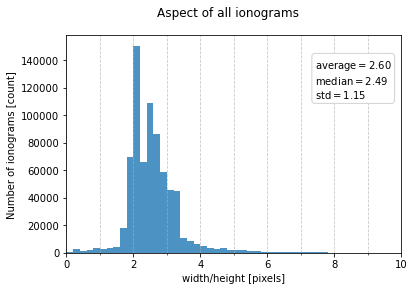

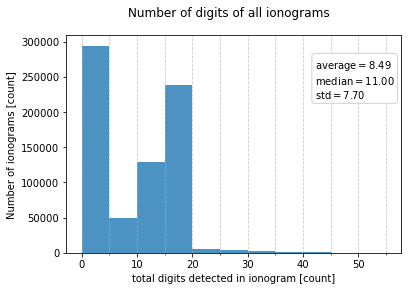

In [49]:
# Make sure everything is an integer
df_result['width']=df_result['width'].astype(int)
df_result['height']=df_result['height'].astype(int)
df_result['digit_count']=df_result['digit_count'].astype(int)
df_result['aspect']=df_result['width']/df_result['height']

aspectPlot(df_result,'Number of ionograms [count]','Aspect of all ionograms')
digitPlot(df_result,'Number of ionograms [count]','Number of digits of all ionograms')

15.0 % of ionograms have w/h < 2
20.18 % of ionograms have w/h >= 3
7.59 % of ionograms have digit_count > 15
47.25 % of ionograms have digit_count < 10


()

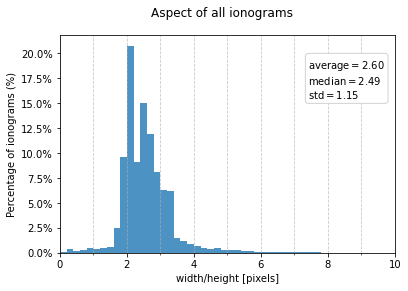

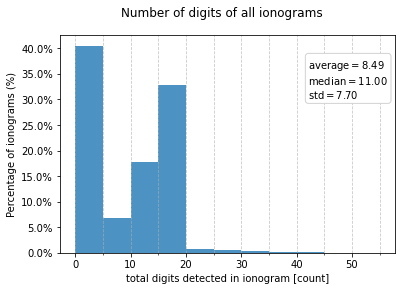

In [50]:
aspectPlot(df_result,'Percentage of ionograms (%)','Aspect of all ionograms',percent=True)
digitPlot(df_result,'Percentage of ionograms (%)','Number of digits of all ionograms',percent=True)

Instead of looking at ionograms, we can look at the overall look of a subdirectory. When there's an error, whether it's out of phase, cropped too soon or irregularly cropped, there's a good chance that more than one image has that error in the subdirectory, which would influence the average and standard deviation metric of the subdirectory. However, if there's less than 10-15 images out of 300-400 with an error (less than 5%), it might look normal. The following code will most likely detect almost all subdirectories with more than 10-15 images containing errors. It will also detect normal subdirectories with no errors, since sometimes there's images of only the metadata, images of the in-between ionograms which don't have normal aspect ratio or digit count and images with no metadata (it was cropped). Low quality subdirectories will also be detected, since it's difficult to read numbers on those.

<ipython-input-51-1da2c9b6a0fa>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_av = df_result.groupby(['Directory','Subdirectory'])['aspect','digit_count'].mean()


0.04 % of ionograms have w/h < 2
0.08 % of ionograms have w/h >= 3
0.01 % of ionograms have digit_count > 15
0.15 % of ionograms have digit_count < 10


()

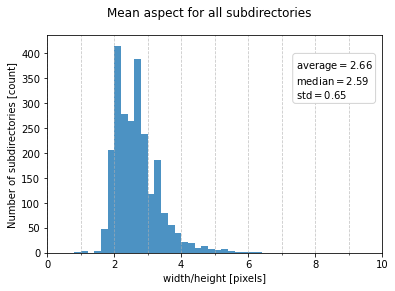

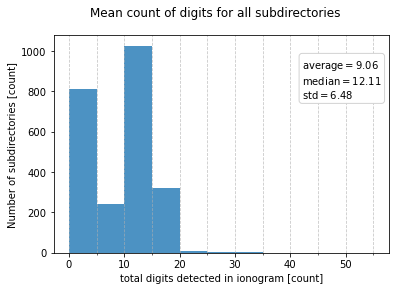

In [51]:
# Calculate mean of metrics for every subdirectory
df_av = df_result.groupby(['Directory','Subdirectory'])['aspect','digit_count'].mean()
df_av.reset_index(inplace=True)

aspectPlot(df_av,'Number of subdirectories [count]','Mean aspect for all subdirectories')
digitPlot(df_av,'Number of subdirectories [count]','Mean count of digits for all subdirectories')

0.04 % of ionograms have w/h < 2
0.08 % of ionograms have w/h >= 3
0.01 % of ionograms have digit_count > 15
0.15 % of ionograms have digit_count < 10


()

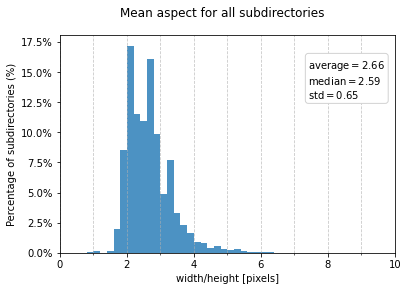

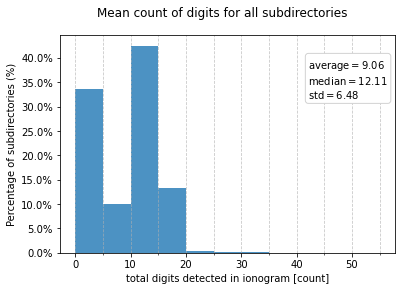

In [52]:
aspectPlot(df_av,'Percentage of subdirectories (%)','Mean aspect for all subdirectories',percent=True)
digitPlot(df_av,'Percentage of subdirectories (%)','Mean count of digits for all subdirectories',percent=True)

<ipython-input-55-cec6ee3a603d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sd = df_result.groupby(['Directory','Subdirectory'])['aspect','digit_count'].std()


0.32 % of ionograms have w/h < 2
0.01 % of ionograms have w/h >= 3
0.0 % of ionograms have digit_count > 15
0.32 % of ionograms have digit_count < 10


()

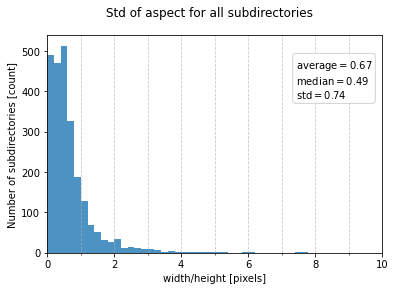

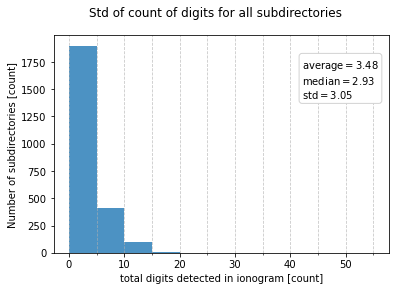

In [55]:
# Calculate sd of metrics for every subdirectory
df_sd = df_result.groupby(['Directory','Subdirectory'])['aspect','digit_count'].std()
df_sd.reset_index(inplace=True)

aspectPlot(df_sd,'Number of subdirectories [count]','Std of aspect for all subdirectories')
digitPlot(df_sd,'Number of subdirectories [count]','Std of count of digits for all subdirectories')

0.32 % of ionograms have w/h < 2
0.01 % of ionograms have w/h >= 3
0.0 % of ionograms have digit_count > 15
0.32 % of ionograms have digit_count < 10


()

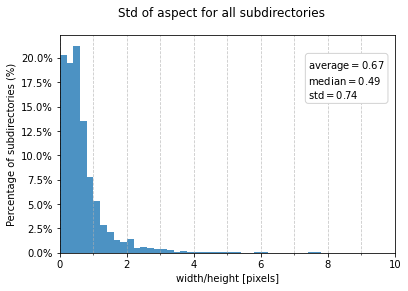

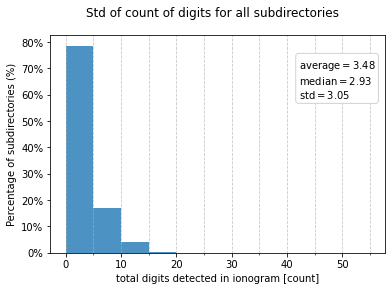

In [56]:
aspectPlot(df_sd,'Percentage of subdirectories (%)','Std of aspect for all subdirectories',percent=True)
digitPlot(df_sd,'Percentage of subdirectories (%)','Std of count of digits for all subdirectories',percent=True)

The next step is to decide the tresholds indicating that there might be a problem with a subdirectory. We make the assumption that errors happen a minority of the time, so we will extract the subdirectories with extreme values only.

For the aspect ratio, anything between 2 and 3 is probably normal, unless there's a lot of numbers or none. As for the digit count, since we are in BATCH_II and it's mostly num2 data, anything with less than 12 or more than 17 numbers on average might contain errors.

It can be interesting to check the aspect ratio vs number of digits in a scatter plot, especially per metadata type. Let's to that before filtering out possible subdirectories containing errors.

Text(0, 0.5, 'digit count')

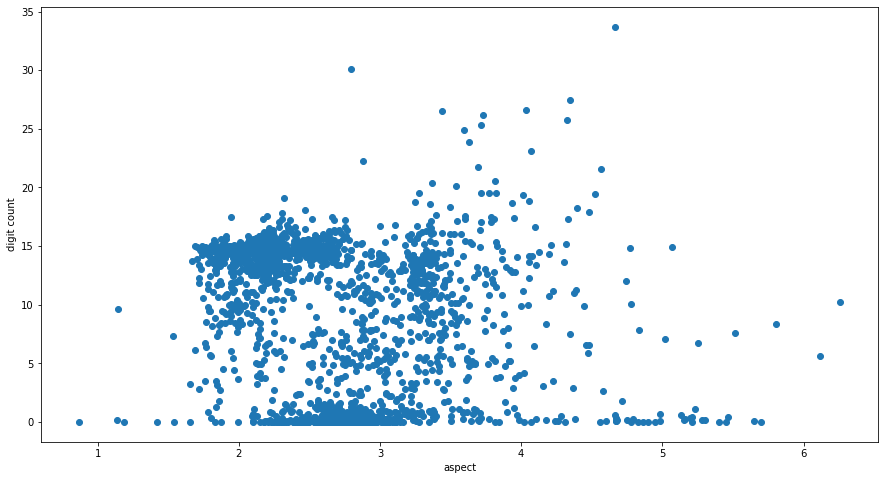

In [57]:
plt.figure(figsize=(15,8))
plt.scatter(df_av['aspect'],df_av['digit_count'])
plt.xlabel('aspect')
plt.ylabel('digit count')